In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        np.random.seed(1)
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))

    def data_generator(self, m, s, n, seed):
        """
        Generates a two-class, two-dimensional dataset using four normal distributions.

        Parameters:
        m : numpy array (2 x 4) -> Mean vectors for the four distributions.
        s : float -> Variance parameter.
        n : int -> Number of points per distribution.
        seed : int (optional) -> Random seed for reproducibility.

        Returns:
        X : numpy array (2, 4*N) -> Generated dataset.
        y : numpy array (4*N,) -> Class labels (+1 or -1).
        """
        np.random.seed(seed)            # Seed for reproducibility
        c = m.shape[1]                  # Number of distributions
        S = s * np.eye(2)               # Covariance matrix
        X_list, y_list = [], []         # Samples and Labels
        for i in range(c):
            samples = np.random.multivariate_normal(m[:, i], S, n).T
            X_list.append(samples)
            y_list.append(np.ones(n) if i < 2 else -np.ones(n))

        X = np.concatenate(X_list, axis=1)
        y = np.concatenate(y_list)

        return X.T, y

    def activation(self, x):                # Tanh Activation Function
        return np.tanh(x)

    def loss(self, y_true, y_pred):         # Mean Square Error
        return np.mean((y_true - y_pred) ** 2)


    def forward(self, X):
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden                                     # wx+b
        self.hidden_output = self.activation(self.hidden_input)                                                         # Tanh(wx+b)
        self.final_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output                    # Tanh(wx+b)*w+b
        self.final_output = self.activation(self.final_input)                                                           # Tanh(Tanh(wx+b)*w+b)
        return self.final_output

    def train(self, X, y, method, epochs, params):
        lr, mc, lr_inc, lr_dec, max_perf_inc = params
        # Momentum initialization
        velocity_ih = np.zeros_like(self.weights_input_hidden)             # Input to Hidden Weights
        velocity_ho = np.zeros_like(self.weights_hidden_output)            # Hidden to Output Weights
        velocity_bh = np.zeros_like(self.bias_hidden)                      # Input to Hidden Bias
        velocity_bo = np.zeros_like(self.bias_output)                      # Hidden to Output Bias
        np.random.seed(1)
        prev_loss = float('inf')
        for epoch in range(epochs):
            output = self.forward(X)
            # Output Layer
            error = output - y.reshape(-1, 1)
            weight_2 = self.hidden_output.T.dot(error * (1 - self.final_output**2))
            bias_2 = np.sum(error * (1 - self.final_output**2), axis=0, keepdims=True)
            # Hidden Layer
            hidden_error = error.dot(self.weights_hidden_output.T) * (1 - self.hidden_output**2)      # d/dx(Tanh(x) = 1 - Tanh^2(x)
            weight_1 = X.T.dot(hidden_error)
            bias_1 = np.sum(hidden_error, axis=0, keepdims=True)

            if method == 1:  # Standard Backpropagation
                # Output Layer
                self.weights_hidden_output -= lr * weight_2                        # w(new) = w(old) - lr*weight
                self.bias_output -= lr * bias_2                                    # b(new) = b(old) - lr*bias
                # Hidden Layer
                self.weights_input_hidden -= lr * weight_1
                self.bias_hidden -= lr * bias_1

            elif method == 2:  # Backpropagation with Momentum
                # Output Layer
                velocity_ho = mc * velocity_ho + lr * weight_2                     # v_w(new) = momentum * v(old) + lr * (hidden_output * error)
                velocity_bo = mc * velocity_bo + lr * bias_2                       # v_b(new) = momentum * v(old) + lr * sum(error)
                self.weights_hidden_output -= velocity_ho
                self.bias_output -= velocity_bo
                # Hidden Layer
                velocity_ih = mc * velocity_ih + lr * weight_1                     # v_w(new) = momentum * v(old) + lr * (X * error)
                velocity_bh = mc * velocity_bh + lr * bias_1                       # v_b(new) = momentum * v(old) + lr * sum(error)
                self.weights_input_hidden -= velocity_ih
                self.bias_hidden -= velocity_bh

            elif method == 3:  # Backpropagation with Adaptive Learning Rate
                loss = self.loss(y.reshape(-1, 1), output)
                # Learning Rate Adjustment
                if loss/prev_loss < 1:
                    lr *= lr_inc  # Increase learning rate
                elif loss/prev_loss > max_perf_inc:
                    lr *= lr_dec  # Decrease learning rate
                prev_loss = loss
                # Output Layer
                self.weights_hidden_output -= lr * weight_2                        # w(new) = w(old) + lr * weight
                self.bias_output -= lr * bias_2                                    # b(new) = b(old) + lr * bias
                # Hidden Layer
                self.weights_input_hidden -= lr * weight_1
                self.bias_hidden -= lr * bias_1

            loss = self.loss(y.reshape(-1, 1), output)
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Loss: {loss:.6f}, Learning Rate: {lr:.6f}')

    def evaluate(self, X, y):
        y_pred = self.forward(X)
        y_pred_class = np.sign(y_pred)
        correct_predictions = np.sum(y_pred_class.flatten() == y)                   # Count correct predictions
        accuracy = correct_predictions / len(y)                                     # Compute accuracy
        return accuracy

    def plot_dec_regions(self,nn_model, lb, ub, lv, uv, rb, rv, m, X, y):
        """
        Plots decision regions produced by a trained neural network
        Parameters:
        - nn_model: Trained neural network object.
        - lb, ub: Lower and upper bounds for horizontal axis.
        - lv, uv: Lower and upper bounds for vertical axis.
        - rb, rv: Resolution parameters for x and y directions.
        - m: Mean vectors of normal distributions.
        - X_train, y_train: Training data used for visualization.
        """
        # Generate mesh grid
        x_range = np.arange(lb, ub, rb)
        y_range = np.arange(lv, uv, rv)
        xx, yy = np.meshgrid(x_range, y_range)

        # Flatten grid and make predictions
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        predictions = nn_model.forward(grid_points)
        predictions = np.sign(predictions)                                          # Convert output to class labels (+1 or -1)
        Z = predictions.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
        plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='*', color='red', label="Class +1")
        plt.scatter(X[y == -1, 0], X[y == -1, 1], marker='o', edgecolor='blue', facecolor='none', label="Class -1")
        plt.scatter(m[0, :], m[1, :], c='black', marker='x', s=100, label="Means")

        # Labels and legend
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.title("Decision Regions")
        plt.legend()
        plt.show()

Experiments 4.2

Epoch 10, Loss: 1.261766, Learning Rate: 0.010000
Epoch 20, Loss: 1.306730, Learning Rate: 0.010000
Epoch 30, Loss: 1.486906, Learning Rate: 0.010000
Epoch 40, Loss: 1.383646, Learning Rate: 0.010000
Epoch 50, Loss: 1.415215, Learning Rate: 0.010000
Epoch 60, Loss: 1.221585, Learning Rate: 0.010000
Epoch 70, Loss: 1.520203, Learning Rate: 0.010000
Epoch 80, Loss: 1.416634, Learning Rate: 0.010000
Epoch 90, Loss: 1.576103, Learning Rate: 0.010000
Epoch 100, Loss: 1.914626, Learning Rate: 0.010000
Epoch 110, Loss: 1.730439, Learning Rate: 0.010000
Epoch 120, Loss: 1.367940, Learning Rate: 0.010000
Epoch 130, Loss: 1.451201, Learning Rate: 0.010000
Epoch 140, Loss: 1.420364, Learning Rate: 0.010000
Epoch 150, Loss: 1.344174, Learning Rate: 0.010000
Epoch 160, Loss: 1.950401, Learning Rate: 0.010000
Epoch 170, Loss: 1.509338, Learning Rate: 0.010000
Epoch 180, Loss: 1.385377, Learning Rate: 0.010000
Epoch 190, Loss: 1.411156, Learning Rate: 0.010000
Epoch 200, Loss: 1.543846, Learning Rate

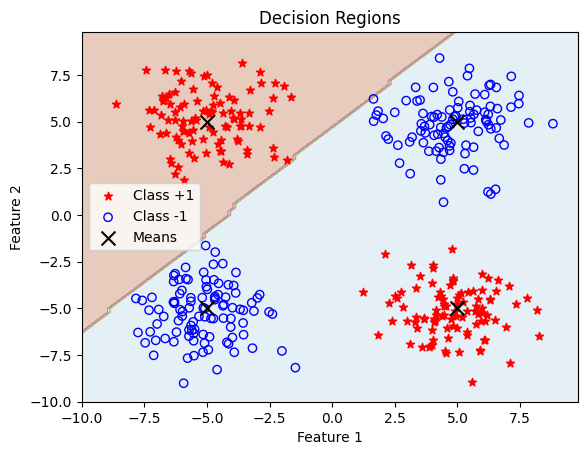

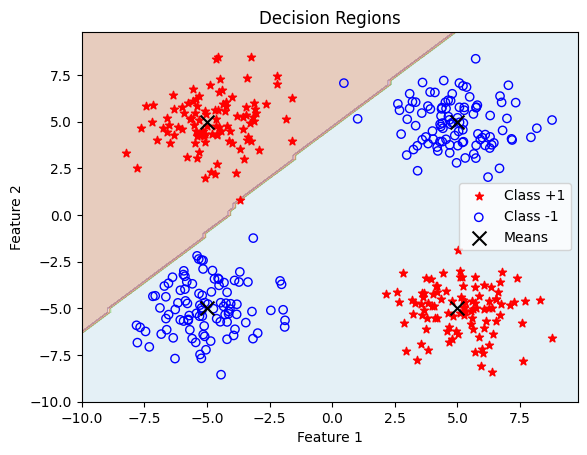

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 2, 100
epochs, learning_rate = 1000, 0.01

mlp = MLP(input_size=2, hidden_size=2, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 1, epochs, [learning_rate,0,0,0,0])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)

Epoch 10, Loss: 1.204615, Learning Rate: 0.010000
Epoch 20, Loss: 1.000652, Learning Rate: 0.010000
Epoch 30, Loss: 1.000568, Learning Rate: 0.010000
Epoch 40, Loss: 1.000506, Learning Rate: 0.010000
Epoch 50, Loss: 1.000459, Learning Rate: 0.010000
Epoch 60, Loss: 1.000423, Learning Rate: 0.010000
Epoch 70, Loss: 1.000393, Learning Rate: 0.010000
Epoch 80, Loss: 1.000368, Learning Rate: 0.010000
Epoch 90, Loss: 1.000347, Learning Rate: 0.010000
Epoch 100, Loss: 1.000329, Learning Rate: 0.010000
Epoch 110, Loss: 1.000313, Learning Rate: 0.010000
Epoch 120, Loss: 1.000299, Learning Rate: 0.010000
Epoch 130, Loss: 1.000286, Learning Rate: 0.010000
Epoch 140, Loss: 1.000275, Learning Rate: 0.010000
Epoch 150, Loss: 1.000265, Learning Rate: 0.010000
Epoch 160, Loss: 1.000255, Learning Rate: 0.010000
Epoch 170, Loss: 1.000246, Learning Rate: 0.010000
Epoch 180, Loss: 1.000238, Learning Rate: 0.010000
Epoch 190, Loss: 1.000230, Learning Rate: 0.010000
Epoch 200, Loss: 1.000223, Learning Rate

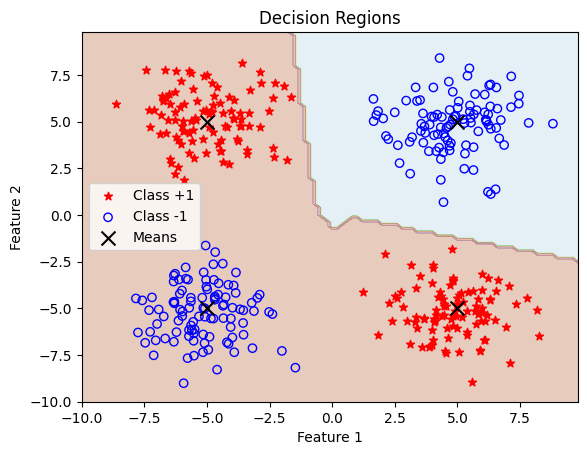

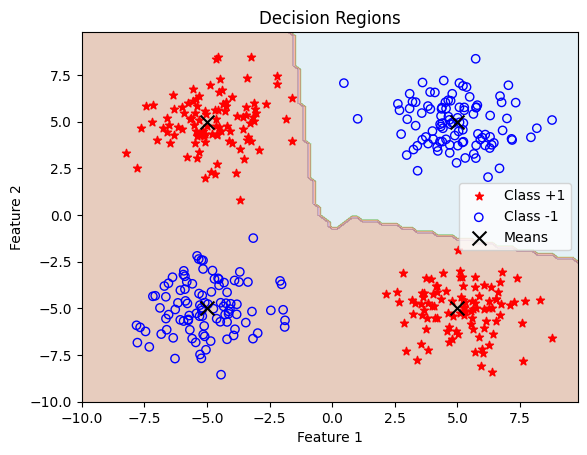

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 2, 100
epochs, learning_rate = 1000, 0.01

mlp = MLP(input_size=2, hidden_size=4, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 1, epochs, [learning_rate,0,0,0,0])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)

Epoch 10, Loss: 1.956918, Learning Rate: 0.010000
Epoch 20, Loss: 1.575165, Learning Rate: 0.010000
Epoch 30, Loss: 1.000680, Learning Rate: 0.010000
Epoch 40, Loss: 1.000198, Learning Rate: 0.010000
Epoch 50, Loss: 1.001040, Learning Rate: 0.010000
Epoch 60, Loss: 1.000339, Learning Rate: 0.010000
Epoch 70, Loss: 1.000209, Learning Rate: 0.010000
Epoch 80, Loss: 1.000151, Learning Rate: 0.010000
Epoch 90, Loss: 1.000118, Learning Rate: 0.010000
Epoch 100, Loss: 1.000097, Learning Rate: 0.010000
Epoch 110, Loss: 1.000082, Learning Rate: 0.010000
Epoch 120, Loss: 1.000071, Learning Rate: 0.010000
Epoch 130, Loss: 1.000063, Learning Rate: 0.010000
Epoch 140, Loss: 1.000056, Learning Rate: 0.010000
Epoch 150, Loss: 1.000051, Learning Rate: 0.010000
Epoch 160, Loss: 1.000047, Learning Rate: 0.010000
Epoch 170, Loss: 1.000043, Learning Rate: 0.010000
Epoch 180, Loss: 1.000040, Learning Rate: 0.010000
Epoch 190, Loss: 1.000037, Learning Rate: 0.010000
Epoch 200, Loss: 1.000035, Learning Rate

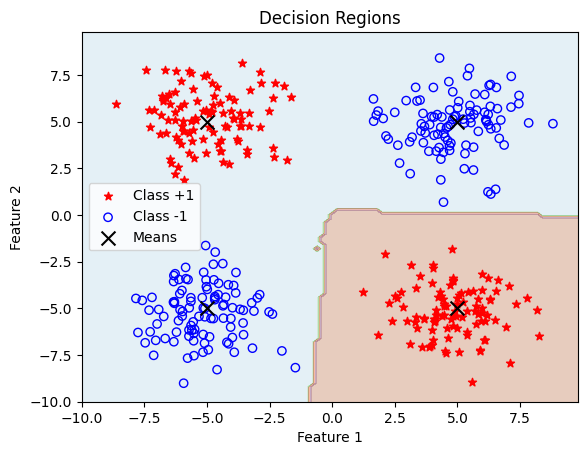

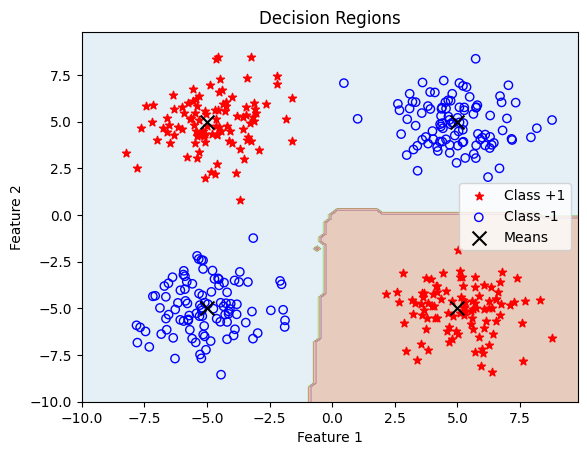

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 2, 100
epochs, learning_rate = 1000, 0.01

mlp = MLP(input_size=2, hidden_size=15, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 1, epochs, [learning_rate,0,0,0,0])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)

Experiments 4.3

Epoch 10, Loss: 1.204615, Learning Rate: 0.010000
Epoch 20, Loss: 1.000652, Learning Rate: 0.010000
Epoch 30, Loss: 1.000568, Learning Rate: 0.010000
Epoch 40, Loss: 1.000506, Learning Rate: 0.010000
Epoch 50, Loss: 1.000459, Learning Rate: 0.010000
Epoch 60, Loss: 1.000423, Learning Rate: 0.010000
Epoch 70, Loss: 1.000393, Learning Rate: 0.010000
Epoch 80, Loss: 1.000368, Learning Rate: 0.010000
Epoch 90, Loss: 1.000347, Learning Rate: 0.010000
Epoch 100, Loss: 1.000329, Learning Rate: 0.010000
Epoch 110, Loss: 1.000313, Learning Rate: 0.010000
Epoch 120, Loss: 1.000299, Learning Rate: 0.010000
Epoch 130, Loss: 1.000286, Learning Rate: 0.010000
Epoch 140, Loss: 1.000275, Learning Rate: 0.010000
Epoch 150, Loss: 1.000265, Learning Rate: 0.010000
Epoch 160, Loss: 1.000255, Learning Rate: 0.010000
Epoch 170, Loss: 1.000246, Learning Rate: 0.010000
Epoch 180, Loss: 1.000238, Learning Rate: 0.010000
Epoch 190, Loss: 1.000230, Learning Rate: 0.010000
Epoch 200, Loss: 1.000223, Learning Rate

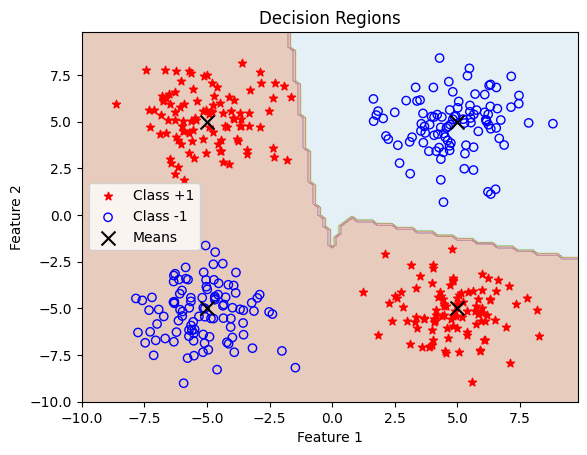

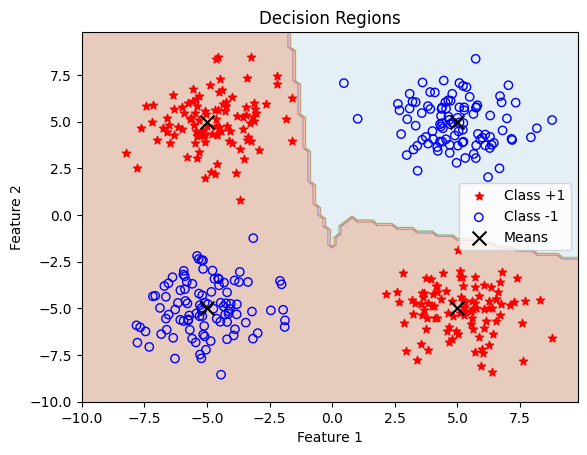

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 2, 100
epochs, learning_rate = 300, 0.01

mlp = MLP(input_size=2, hidden_size=4, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 1, epochs, [learning_rate,0,0,0,0])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)

Epoch 10, Loss: 1.172341, Learning Rate: 0.001000
Epoch 20, Loss: 1.081511, Learning Rate: 0.001000
Epoch 30, Loss: 1.053521, Learning Rate: 0.001000
Epoch 40, Loss: 1.037416, Learning Rate: 0.001000
Epoch 50, Loss: 1.027980, Learning Rate: 0.001000
Epoch 60, Loss: 1.022035, Learning Rate: 0.001000
Epoch 70, Loss: 1.018028, Learning Rate: 0.001000
Epoch 80, Loss: 1.015176, Learning Rate: 0.001000
Epoch 90, Loss: 1.013058, Learning Rate: 0.001000
Epoch 100, Loss: 1.011431, Learning Rate: 0.001000
Epoch 110, Loss: 1.010147, Learning Rate: 0.001000
Epoch 120, Loss: 1.009127, Learning Rate: 0.001000
Epoch 130, Loss: 1.009074, Learning Rate: 0.001000
Epoch 140, Loss: 1.024567, Learning Rate: 0.001000
Epoch 150, Loss: 0.875350, Learning Rate: 0.001000
Epoch 160, Loss: 0.702194, Learning Rate: 0.001000
Epoch 170, Loss: 0.363457, Learning Rate: 0.001000
Epoch 180, Loss: 0.070551, Learning Rate: 0.001000
Epoch 190, Loss: 0.061171, Learning Rate: 0.001000
Epoch 200, Loss: 0.058866, Learning Rate

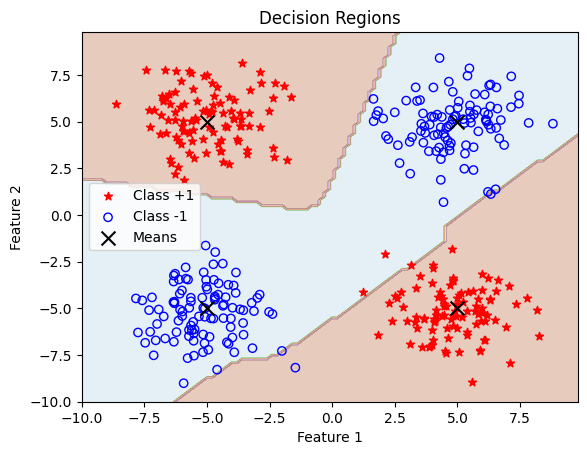

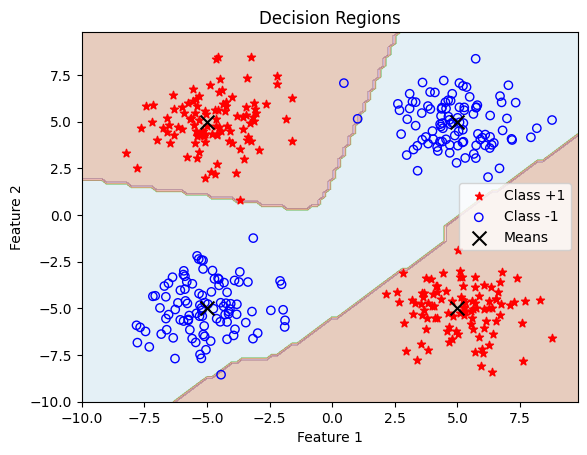

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 2, 100
epochs, learning_rate = 300, 0.001

mlp = MLP(input_size=2, hidden_size=4, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 1, epochs, [learning_rate,0,0,0,0])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)

Epoch 10, Loss: 1.204615, Learning Rate: 0.010000
Epoch 20, Loss: 1.000652, Learning Rate: 0.010000
Epoch 30, Loss: 1.000568, Learning Rate: 0.010000
Epoch 40, Loss: 1.000506, Learning Rate: 0.010000
Epoch 50, Loss: 1.000459, Learning Rate: 0.010000
Epoch 60, Loss: 1.000423, Learning Rate: 0.010000
Epoch 70, Loss: 1.000393, Learning Rate: 0.010000
Epoch 80, Loss: 1.000368, Learning Rate: 0.010000
Epoch 90, Loss: 1.000347, Learning Rate: 0.010000
Epoch 100, Loss: 1.000329, Learning Rate: 0.010000
Epoch 110, Loss: 1.000313, Learning Rate: 0.010000
Epoch 120, Loss: 1.000299, Learning Rate: 0.010000
Epoch 130, Loss: 1.000286, Learning Rate: 0.010000
Epoch 140, Loss: 1.000275, Learning Rate: 0.010000
Epoch 150, Loss: 1.000265, Learning Rate: 0.010000
Epoch 160, Loss: 1.000255, Learning Rate: 0.010000
Epoch 170, Loss: 1.000246, Learning Rate: 0.010000
Epoch 180, Loss: 1.000238, Learning Rate: 0.010000
Epoch 190, Loss: 1.000230, Learning Rate: 0.010000
Epoch 200, Loss: 1.000223, Learning Rate

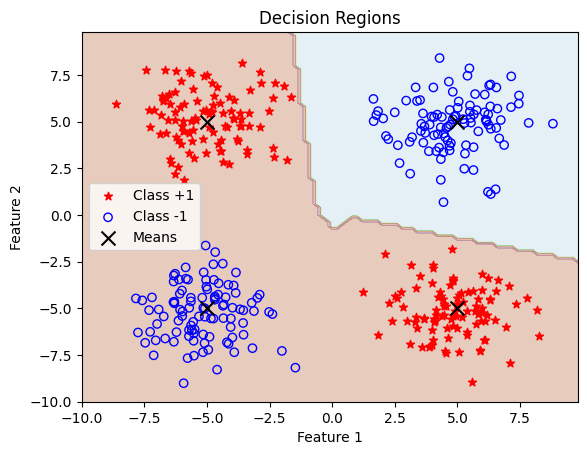

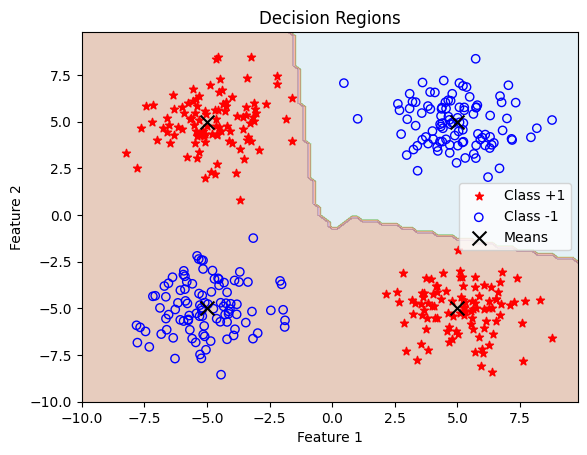

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 2, 100
epochs, learning_rate = 1000, 0.01

mlp = MLP(input_size=2, hidden_size=4, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 1, epochs, [learning_rate,0,0,0,0])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)

Epoch 10, Loss: 1.172341, Learning Rate: 0.001000
Epoch 20, Loss: 1.081511, Learning Rate: 0.001000
Epoch 30, Loss: 1.053521, Learning Rate: 0.001000
Epoch 40, Loss: 1.037416, Learning Rate: 0.001000
Epoch 50, Loss: 1.027980, Learning Rate: 0.001000
Epoch 60, Loss: 1.022035, Learning Rate: 0.001000
Epoch 70, Loss: 1.018028, Learning Rate: 0.001000
Epoch 80, Loss: 1.015176, Learning Rate: 0.001000
Epoch 90, Loss: 1.013058, Learning Rate: 0.001000
Epoch 100, Loss: 1.011431, Learning Rate: 0.001000
Epoch 110, Loss: 1.010147, Learning Rate: 0.001000
Epoch 120, Loss: 1.009127, Learning Rate: 0.001000
Epoch 130, Loss: 1.009074, Learning Rate: 0.001000
Epoch 140, Loss: 1.024567, Learning Rate: 0.001000
Epoch 150, Loss: 0.875350, Learning Rate: 0.001000
Epoch 160, Loss: 0.702194, Learning Rate: 0.001000
Epoch 170, Loss: 0.363457, Learning Rate: 0.001000
Epoch 180, Loss: 0.070551, Learning Rate: 0.001000
Epoch 190, Loss: 0.061171, Learning Rate: 0.001000
Epoch 200, Loss: 0.058866, Learning Rate

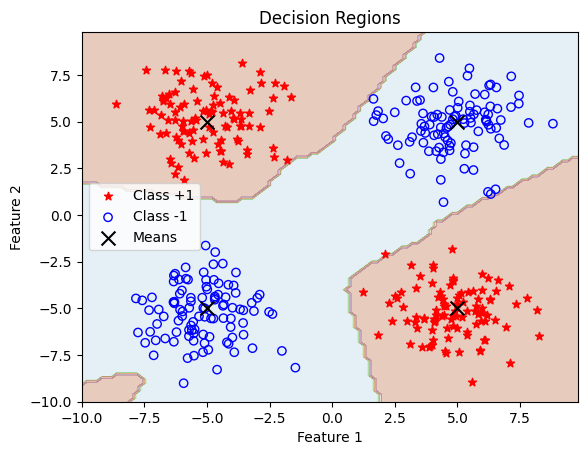

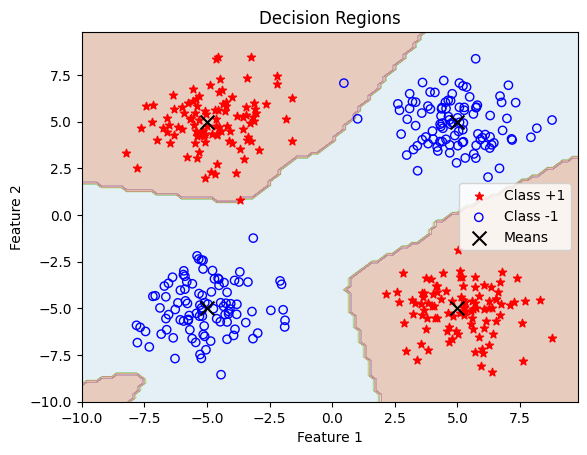

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 2, 100
epochs, learning_rate = 1000, 0.001

mlp = MLP(input_size=2, hidden_size=4, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 1, epochs, [learning_rate,0,0,0,0])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)

Experiments 4.4

Epoch 10, Loss: 1.153086, Learning Rate: 0.006895
Epoch 20, Loss: 1.005290, Learning Rate: 0.007487
Epoch 30, Loss: 0.874584, Learning Rate: 0.005420
Epoch 40, Loss: 0.494841, Learning Rate: 0.002616
Epoch 50, Loss: 0.057906, Learning Rate: 0.002706
Epoch 60, Loss: 0.052673, Learning Rate: 0.004407
Epoch 70, Loss: 0.056425, Learning Rate: 0.003750
Epoch 80, Loss: 0.061740, Learning Rate: 0.003191
Epoch 90, Loss: 0.050947, Learning Rate: 0.002993
Epoch 100, Loss: 0.052742, Learning Rate: 0.003820
Epoch 110, Loss: 0.056683, Learning Rate: 0.004643
Epoch 120, Loss: 0.048458, Learning Rate: 0.002904
Epoch 130, Loss: 0.049655, Learning Rate: 0.003706
Epoch 140, Loss: 0.048536, Learning Rate: 0.003476
Epoch 150, Loss: 0.034994, Learning Rate: 0.003424
Epoch 160, Loss: 0.021497, Learning Rate: 0.003718
Epoch 170, Loss: 0.016988, Learning Rate: 0.002564
Epoch 180, Loss: 0.015203, Learning Rate: 0.002525
Epoch 190, Loss: 0.013996, Learning Rate: 0.002369
Epoch 200, Loss: 0.013157, Learning Rate

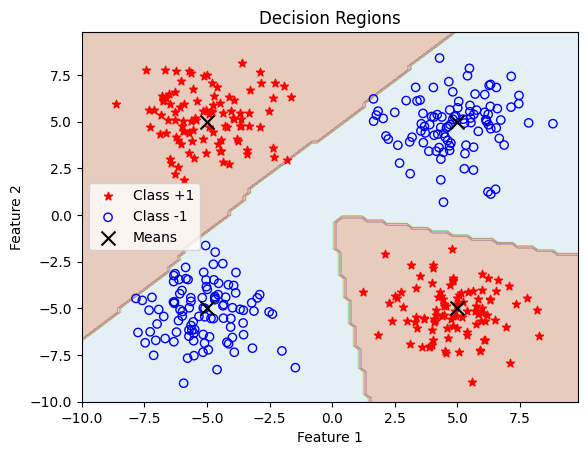

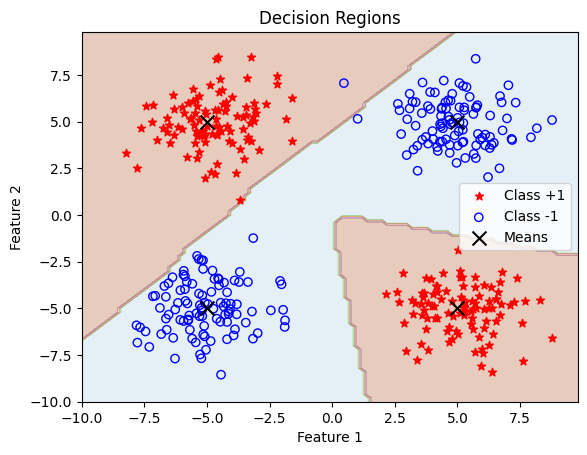

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 2, 100
epochs, learning_rate = 300, 0.01

mlp = MLP(input_size=2, hidden_size=4, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 3, epochs, [learning_rate,0,1.05,0.7,1.04])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)

Epoch 10, Loss: 1.934026, Learning Rate: 0.010000
Epoch 20, Loss: 1.883453, Learning Rate: 0.010000
Epoch 30, Loss: 0.938969, Learning Rate: 0.010000
Epoch 40, Loss: 0.953359, Learning Rate: 0.010000
Epoch 50, Loss: 0.661894, Learning Rate: 0.010000
Epoch 60, Loss: 0.291938, Learning Rate: 0.010000
Epoch 70, Loss: 0.221018, Learning Rate: 0.010000
Epoch 80, Loss: 0.172312, Learning Rate: 0.010000
Epoch 90, Loss: 0.471906, Learning Rate: 0.010000
Epoch 100, Loss: 0.162720, Learning Rate: 0.010000
Epoch 110, Loss: 0.151289, Learning Rate: 0.010000
Epoch 120, Loss: 0.082490, Learning Rate: 0.010000
Epoch 130, Loss: 0.349414, Learning Rate: 0.010000
Epoch 140, Loss: 0.086549, Learning Rate: 0.010000
Epoch 150, Loss: 0.264374, Learning Rate: 0.010000
Epoch 160, Loss: 0.366503, Learning Rate: 0.010000
Epoch 170, Loss: 0.240878, Learning Rate: 0.010000
Epoch 180, Loss: 0.156388, Learning Rate: 0.010000
Epoch 190, Loss: 0.156534, Learning Rate: 0.010000
Epoch 200, Loss: 0.290428, Learning Rate

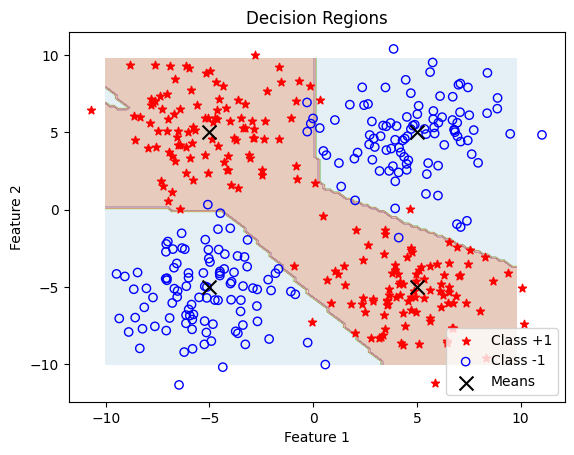

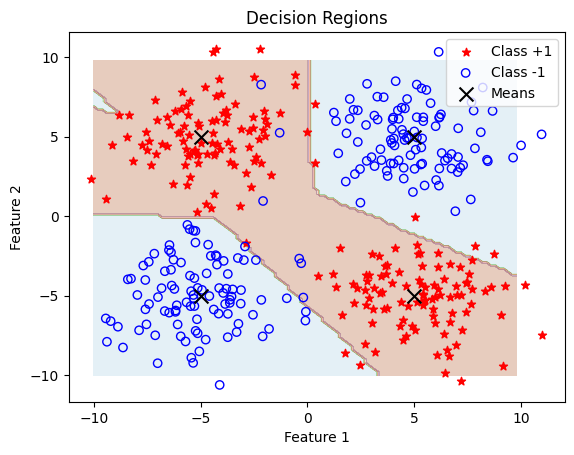

In [ ]:
m = np.array([[-5, 5, 5, -5], [5, -5, 5, -5]])
s, n = 5, 100
epochs, learning_rate = 300, 0.01

mlp = MLP(input_size=2, hidden_size=5, output_size=1)
X_train, y_train = mlp.data_generator(m, s, n, 0)
X_test, y_test = mlp.data_generator(m, s, n, 10)
mlp.train(X_train, y_train, 1, epochs, [learning_rate,0,0,0,0])
accuracy1,accuracy2 = mlp.evaluate(X_train, y_train),mlp.evaluate(X_test, y_test)
print(f"Train Accuracy: {accuracy1*100:.4f}, Test Accuracy: {accuracy2*100:.4f}\n")

mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_train, y=y_train)
mlp.plot_dec_regions(mlp,lb=-10, ub=10, lv=-10, uv=10,rb=0.2, rv=0.2,m=m,X=X_test, y=y_test)